###### <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 04**: Data Unions & Joins Pipeline

**Date**: September 26th 2025

**Student Name**: Ana Valeria Oliva Hernández

**Professor**: Pablo Camarillo Ramirez

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on SparkSQL") \
    .master("spark://265c3f081fa3:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/26 13:31:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Import your module
from valeriaoliva.spark_utils import SparkUtils

In [3]:
# Build schemas
schema_agencies = SparkUtils.generate_schema([("agency_id", "int"), ("agency_info", "string")])
df_agencies = spark.read.schema(schema_agencies).option("header", True).csv("/opt/spark/work-dir/data/car_service/agencies")

schema_cars = SparkUtils.generate_schema([("car_id", "int"), ("car_info", "string")])
df_cars = spark.read.schema(schema_cars).option("header", True).csv("/opt/spark/work-dir/data/car_service/cars")

schema_customers = SparkUtils.generate_schema([("customer_id", "int"), ("customer_info", "string")])
df_customers = spark.read.schema(schema_customers).option("header", True).csv("/opt/spark/work-dir/data/car_service/customers")

schema_rentals = SparkUtils.generate_schema([("rental_id", "int"), ("rental_info", "string")])
df_rentals = spark.read.schema(schema_rentals).option("header", True).csv("/opt/spark/work-dir/data/car_service/rentals")

In [4]:
# Import get_json_object
from pyspark.sql.functions import get_json_object

In [5]:
df_rentals = df_rentals.withColumn("car_id", get_json_object(df_rentals.rental_info,"$.car_id").cast("int")).withColumn("customer_id", get_json_object(df_rentals.rental_info,"$.customer_id").cast("int")).withColumn("agency_id", get_json_object(df_rentals.rental_info,"$.agency_id").cast("int")).select("rental_id","car_id","customer_id","agency_id")

df_cars = df_cars.withColumn("car_name", get_json_object(df_cars.car_info,"$.car_name")).select("car_id","car_name")

df_agencies = df_agencies.withColumn("agency_name", get_json_object(df_agencies.agency_info,"$.agency_name")).select("agency_id","agency_name")

df_customers = df_customers.withColumn("customer_name", get_json_object(df_customers.customer_info,"$.customer_name")).select("customer_id","customer_name")

In [7]:
df = (df_rentals.join(df_cars, on="car_id", how="left")
    .join(df_agencies, on="agency_id", how="left")
    .join(df_customers, on="customer_id", how="left")
    .drop("agency_id", "customer_id", "car_id"))
df.show(truncate=False)

+---------+-----------------------------------+-------------+---------------+
|rental_id|car_name                           |agency_name  |customer_name  |
+---------+-----------------------------------+-------------+---------------+
|11891    |Wallace-Carlson Model 9            |NYC Rentals  |Margaret Jones |
|11892    |Grimes-Green Model 8               |LA Car Rental|Albert Williams|
|11893    |Stewart-Allen Model 5              |SF Cars      |Caleb Fleming  |
|11894    |Campos PLC Model 4                 |NYC Rentals  |Andrew Butler  |
|11895    |Wagner LLC Model 1                 |SF Cars      |Kristin Potts  |
|11896    |Jones, Jefferson and Rivera Model 7|LA Car Rental|Jeremy Parks   |
|11897    |Lopez and Sons Model 9             |Zapopan Auto |Terry Wells    |
|11898    |Salazar Ltd Model 8                |SF Cars      |Marc Williams  |
|11899    |Villanueva PLC Model 7             |LA Car Rental|Danny Williams |
|11900    |Faulkner-Howard Model 5            |SF Cars      |Eri

In [8]:
#Parquet file
!pwd

/opt/spark/work-dir/labs/lab04


In [10]:
!du -sh /opt/spark/work-dir/data/car_service/rentals

1.1M	/opt/spark/work-dir/data/car_service/rentals


In [11]:
base_path = "/opt/spark/work-dir/data/"

df.write \
    .mode("overwrite") \
    .parquet(base_path + "car_service/output/parquet")

In [13]:
!ls /opt/spark/work-dir/data/car_service/output/parquet/

part-00000-5e212912-ef5b-4cd1-a340-34262a29ac11-c000.snappy.parquet  _SUCCESS
part-00001-5e212912-ef5b-4cd1-a340-34262a29ac11-c000.snappy.parquet


In [14]:
!du -sh /opt/spark/work-dir/data/car_service/output/parquet/

124K	/opt/spark/work-dir/data/car_service/output/parquet/


In [15]:
df.write \
    .partitionBy("agency_name") \
    .mode("overwrite") \
    .parquet(base_path + "car_service/output/parquet")

In [16]:
!ls /opt/spark/work-dir/data/car_service/output/parquet/

'agency_name=LA Car Rental'  'agency_name=SF Cars'	  _SUCCESS
'agency_name=NYC Rentals'    'agency_name=Zapopan Auto'


In [19]:
!du -sh /opt/spark/work-dir/data/car_service/output/parquet/

144K	/opt/spark/work-dir/data/car_service/output/parquet/


In [23]:
df.write \
            .partitionBy("agency_name") \
            .mode("overwrite") \
            .option("header", True) \
            .csv(base_path + "car_service/output/csv")

In [24]:
!ls /opt/spark/work-dir/data/car_service/output/csv

'agency_name=LA Car Rental'  'agency_name=SF Cars'	  _SUCCESS
'agency_name=NYC Rentals'    'agency_name=Zapopan Auto'


In [25]:
!du -sh /opt/spark/work-dir/data/car_service/output/csv

856K	/opt/spark/work-dir/data/car_service/output/csv


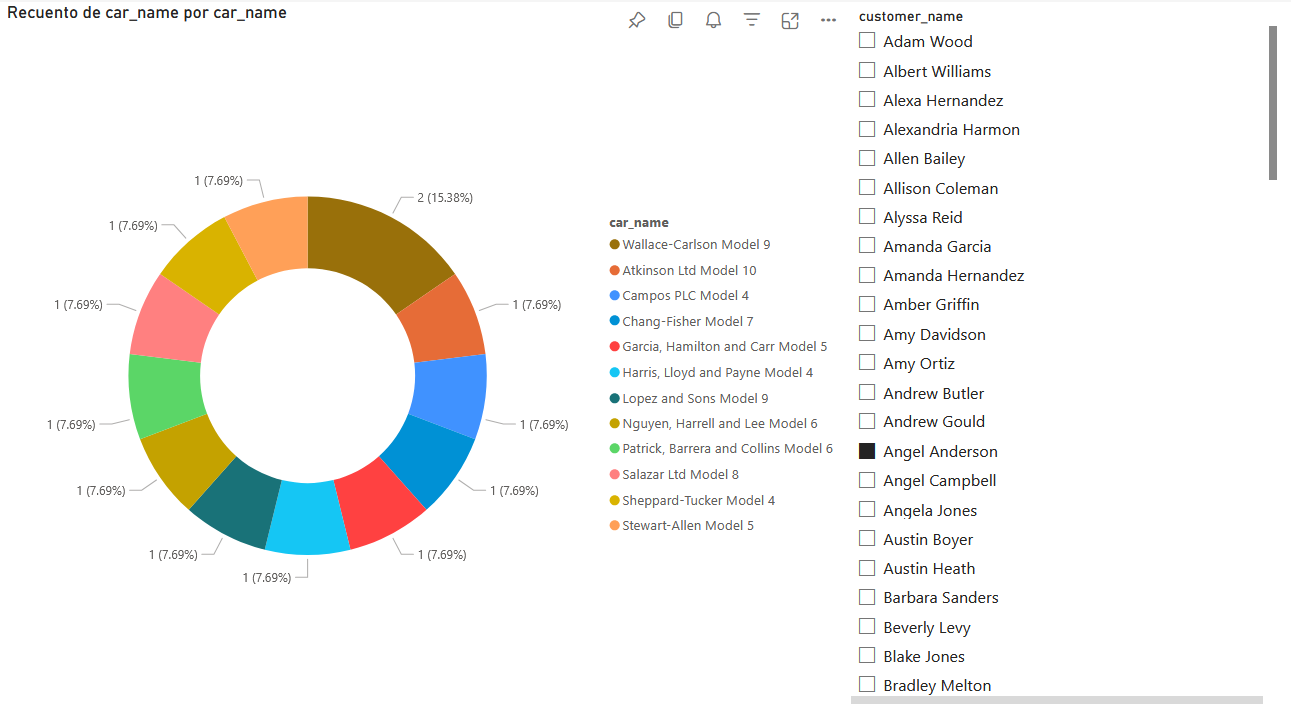

In [ ]:
sc.stop()